Using device: cpu
Epoch [5/20], Loss: 0.5660
Epoch [10/20], Loss: 0.1478
Epoch [15/20], Loss: 0.0061
Epoch [20/20], Loss: 0.0020
Test Accuracy: 47.00%
True Class Distribution:  [102  98]
Predicted Class Distribution:  [116  84]


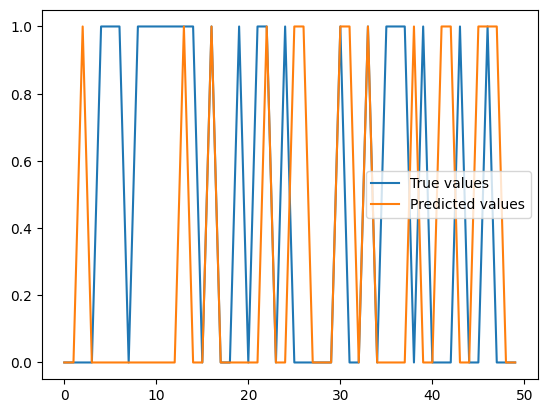

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Check if CUDA is available for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SelfSupervisedModel(nn.Module):
    def __init__(self):
        super(SelfSupervisedModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Output layer should only output one value per sample (binary classification)
        self.decoder = nn.Sequential(
            nn.Linear(16, 1),  # Change to output a single value for binary classification
            nn.Sigmoid()       # Apply sigmoid for probability between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Instantiate model and move it to the appropriate device (GPU/CPU)
model = SelfSupervisedModel().to(device)

# Create a synthetic biomedical-like dataset
def generate_biomedical_data(samples=1000, input_dim=128):
    # Random data to simulate multi-modal biomedical features
    X = np.random.rand(samples, input_dim)
    return X

# Load the data
X_data = generate_biomedical_data(samples=1000, input_dim=128)
y_data = np.random.randint(0, 2, size=(1000,))  # Binary classification for illustration

# Preprocess and standardize the data
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Training loop with BCELoss
def train(model, X_train, y_train, epochs=10, batch_size=32, learning_rate=0.001):
    model.train()
    criterion = nn.BCELoss()  # Use Binary Cross-Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size(0))
        
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)  # Squeeze output to match target shape
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Train the model
train(model, X_train_tensor, y_train_tensor, epochs=20, batch_size=64)

# Evaluation loop
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # Forward pass
        outputs = model(X_test)
        
        # Convert to binary predictions (0 or 1) based on the 0.5 threshold
        predictions = (outputs > 0.5).float().cpu().numpy()  # Convert to CPU and NumPy
        
        # Flatten predictions to 1D array
        predictions = predictions.flatten()
        
        # Convert y_test to NumPy if it's a tensor
        y_test_numpy = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
        
        # Flatten y_test to 1D array
        y_test_numpy = y_test_numpy.flatten()

        # Ensure both predictions and y_test have the same length
        assert len(predictions) == len(y_test_numpy), f"Mismatch in length: {len(predictions)} vs {len(y_test_numpy)}"
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test_numpy, predictions)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Evaluate the model on the test set
evaluate(model, X_test_tensor, y_test_tensor)

# Benchmarking the performance across distributed systems
def benchmark_tensorflow_model():
    # Define a simple neural network for benchmarking
    model_tf = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(128,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    
    model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model_tf.fit(X_train, y_train, epochs=10, batch_size=64)

# You can benchmark this model across different machines or GPUs if running in a distributed setup
# benchmark_tensorflow_model()

# Check bias in predictions
def check_bias_in_data(y_true, y_pred):
    # Simple bias check: check class distribution imbalance
    y_pred = y_pred.flatten()  # Flatten predictions to ensure it's a 1D array
    class_distribution_true = np.bincount(y_true)
    class_distribution_pred = np.bincount(y_pred)
    
    print("True Class Distribution: ", class_distribution_true)
    print("Predicted Class Distribution: ", class_distribution_pred)
    
    if class_distribution_true[0] / sum(class_distribution_true) < 0.4:
        print("Warning: Potential Bias in the Class Distribution")

# Check bias in predictions
check_bias_in_data(y_test, (model(X_test_tensor) > 0.5).cpu().numpy().astype(int))

plt.plot(y_test[:50], label="True values")
plt.plot((model(X_test_tensor)[:50] > 0.5).cpu().numpy(), label="Predicted values")
plt.legend()
plt.show()
